<a href="https://colab.research.google.com/github/AmirHoseein99/Depression-Engine/blob/master/DepressionDetecion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import pickle
import librosa
import sklearn
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import librosa.display
import tensorflow as tf
from keras import layers  
from tensorflow import keras
from collections import Counter
from bottleneck import partition
from matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy import stats

In [ ]:
max_transcripts_path = "/content/drive/MyDrive/Transcript/Max"
min_transcripts_path = "/content/drive/MyDrive/Transcript/Min"

In [ ]:
def readTranscripts(path):
  all_transcripts = {}
  all_files = glob.glob(path + "/*")
  for filename in all_files:
      id = int(filename.split("/")[6].split("_")[0])
      trainscript = pd.read_csv(filename, sep='\t')
      all_transcripts[id] = trainscript
  return all_transcripts

In [ ]:
max_transcripts = readTranscripts(max_transcripts_path)
min_transcripts =  readTranscripts(min_transcripts_path)

In [ ]:
max_transcripts[308][:10]

,start_time,stop_time,speaker,value
0,33.736,36.456,Ellie,hi i'm ellie thanks for coming in today
1,37.076,40.306,Ellie,i was created to talk to people in a safe and ...
2,40.976,45.326,Ellie,think of me as a friend i don't judge i can't ...
3,46.306,55.786,Ellie,i'm here to learn about people and would love ...
4,56.766,57.996,Ellie,where are you from originally
5,59.256,60.676,Participant,los angeles california
6,61.586,62.036,Ellie,really
7,62.976,63.376,Participant,yes
8,63.386,65.346,Ellie,what are some things you really like about l_a
9,66.406,74.826,Participant,um the southern california lifestyle the beach...


In [ ]:
def extract_response_times (transcript) :
  response_times = []
  for i in range(len(transcript)):
    if i > 0:
      j = i - 1
      if transcript.iloc[i].speaker == "Participant":
        if transcript.iloc[j].speaker != "Participant":
          response_time = transcript.iloc[i].start_time - transcript.iloc[j].stop_time
          response_time = float("{:.2f}".format(response_time))
          response_times.append(response_time)
  return np.array(response_times)

In [ ]:
def extract_pause_times (transcript):
  puase_times=[]
  pauses_nums = 0
  for i in range(len(transcript)):
    if i > 0:
      j = i - 1
      if transcript.iloc[i].speaker == "Participant":
        if transcript.iloc[j].speaker == "Participant":
          pause_time = transcript.iloc[i].start_time - transcript.iloc[j].stop_time
          pause_time = float("{:.2f}".format(pause_time))
          pauses_nums = pauses_nums + 1
          puase_times.append(pause_time)
  return np.array(puase_times), pauses_nums

In [ ]:
num_pauses = {}
pause_times = {}
response_times = {}
for k in max_transcripts.keys():
  transcript = max_transcripts[k]
  pause_time, pauses_nums = extract_pause_times(transcript)
  response_time = extract_response_times(transcript)
  pause_times[k] = pause_time
  response_times[k] = response_time
  num_pauses[k] = pauses_nums

In [ ]:
for k in min_transcripts.keys():
  transcript = min_transcripts[k]
  pause_time, pauses_nums = extract_pause_times(transcript)
  response_time = extract_response_times(transcript)
  pause_times[k] = pause_time
  response_times[k] = response_time
  num_pauses[k] = pauses_nums

In [ ]:
transcript_featuers = pd.DataFrame()
transcript_featuers["id"] = list(pause_times.keys())
transcript_featuers["response_time"] = list(response_times.values())
transcript_featuers["number_of_pauses"] = list(num_pauses.values())
transcript_featuers["pause_times"] = list(pause_times.values())
transcript_featuers["PHQ8_Score"] = [23, 22, 21, 0, 0, 0]

In [ ]:
transcript_featuers[["id", "PHQ8_Score"]]

In [ ]:
transcript_featuers["PHQ8_bin"] = [1, 1, 1, 0, 0, 0]

In [ ]:
transcript_featuers

,id,response_time,number_of_pauses,pause_times,PHQ8_Score,PHQ8_bin
0,346,"[0.12, 0.35, 0.63, 1.13, 0.27, 0.57, 0.62, 1.1...",226,"[0.7, 0.75, 2.87, 0.53, 0.63, 0.37, 0.7, 0.54,...",23,1
1,311,"[0.52, 1.33, 2.65, 1.19, 1.61, 1.04, 0.62, 1.1...",61,"[0.61, 0.9, 0.94, 0.47, 0.88, 0.94, 0.84, 1.04...",22,1
2,308,"[1.26, 0.94, 1.06, 0.21, 6.3, 2.89, 2.28, -1.7...",104,"[1.11, 1.04, 1.39, 1.52, 5.83, 1.05, 2.78, 1.9...",21,1
3,364,"[0.06, 0.45, 0.81, 0.7, 1.03, 0.31, 0.39, 0.1,...",312,"[0.49, 0.28, 0.59, 0.79, 0.21, 0.21, 0.57, 0.5...",0,0
4,363,"[0.15, 0.57, 0.81, 1.13, 0.7, 0.7, 0.03, 0.71,...",121,"[0.78, 0.51, 0.56, 0.46, 0.57, 0.67, 0.75, 0.6...",0,0
5,303,"[0.28, 0.35, 0.13, 0.46, 0.63, 0.54, 0.25, 1.0...",46,"[1.72, 0.5, 0.49, 0.98, 1.18, 0.56, 0.53, 0.6,...",0,0


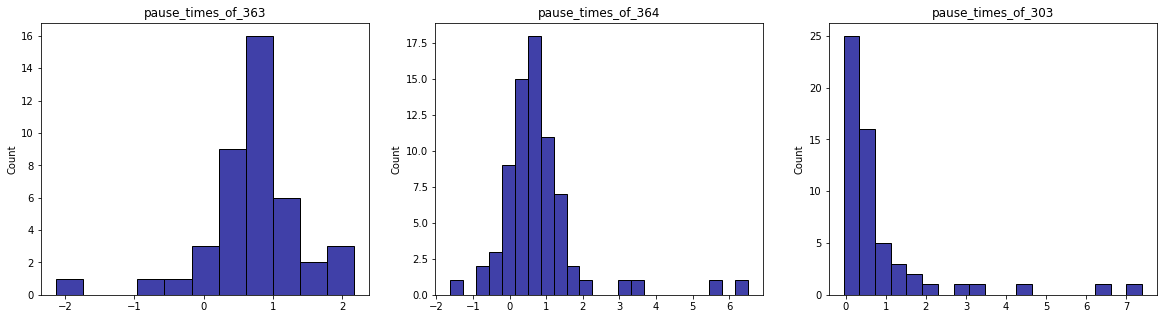

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20,5))
i = 0
for k in  transcript_featuers[transcript_featuers.PHQ8_Score == 0].id.to_numpy():
  sns.histplot(data=transcript_featuers[transcript_featuers.id == k].response_time.to_numpy()[0], ax=axs[i], color="darkblue").set_title(f"pause_times_of_{k}")
  # sns.histplot(data=transcript_featuers[transcript_featuers.id == k].response_time.to_numpy()[0], ax=axs[1, i], color="firebrick").set_title(f"response_times_of_{k}")
  i = i+1

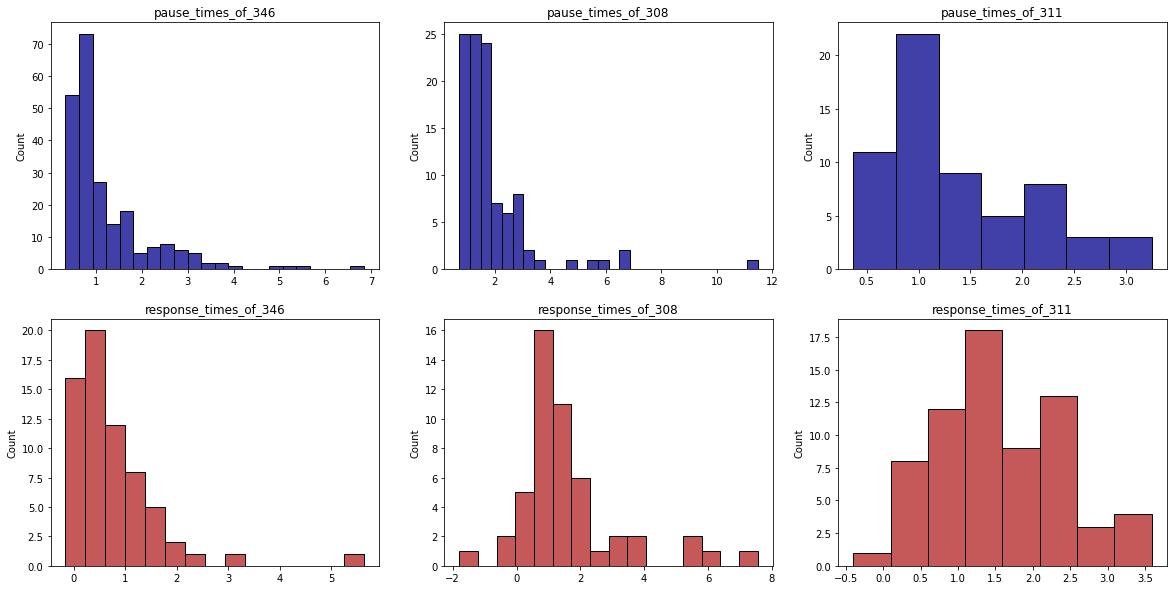

In [ ]:
|fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20,10))
i = 0
for k in max_pauses.keys():
  sns.histplot(data=max_pauses[k], ax=axs[0, i], color="darkblue").set_title(f"pause_times_of_{k}")
  sns.histplot(data=max_responses[k], ax=axs[1, i], color="firebrick").set_title(f"response_times_of_{k}")
  i = i+1

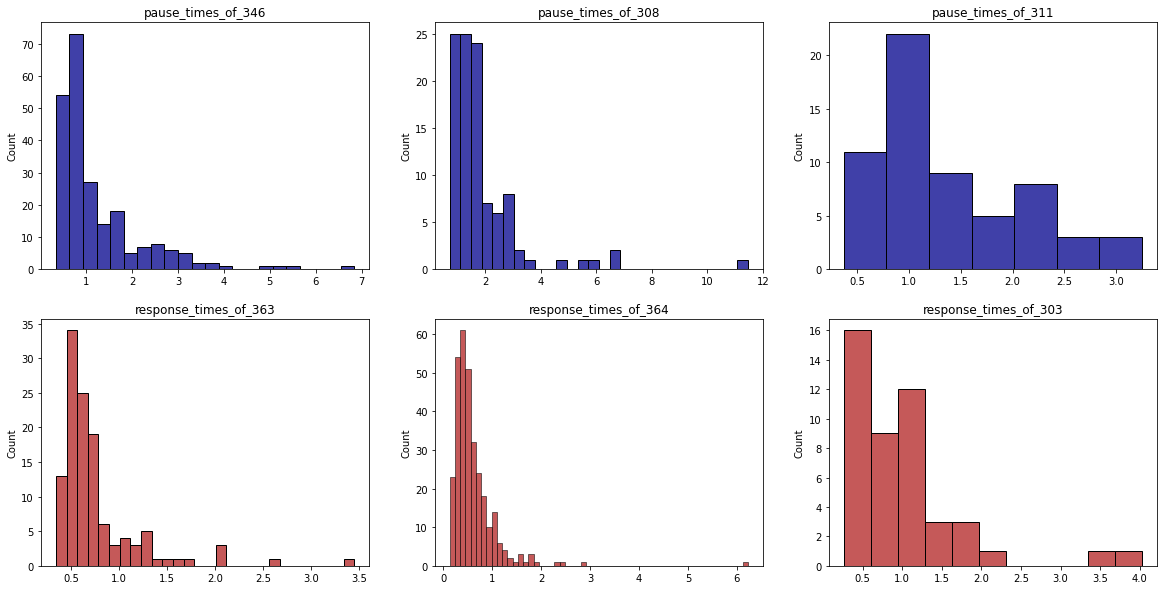

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20,10))
i = 0
for k in max_pauses.keys():
  sns.histplot(data=max_pauses[k], ax=axs[0, i], color="darkblue").set_title(f"pause_times_of_{k}")
  i = i+1
i = 0
for k in min_pauses.keys():
  sns.histplot(data=min_pauses[k], ax=axs[1, i], color="firebrick").set_title(f"response_times_of_{k}")
  i = i+1

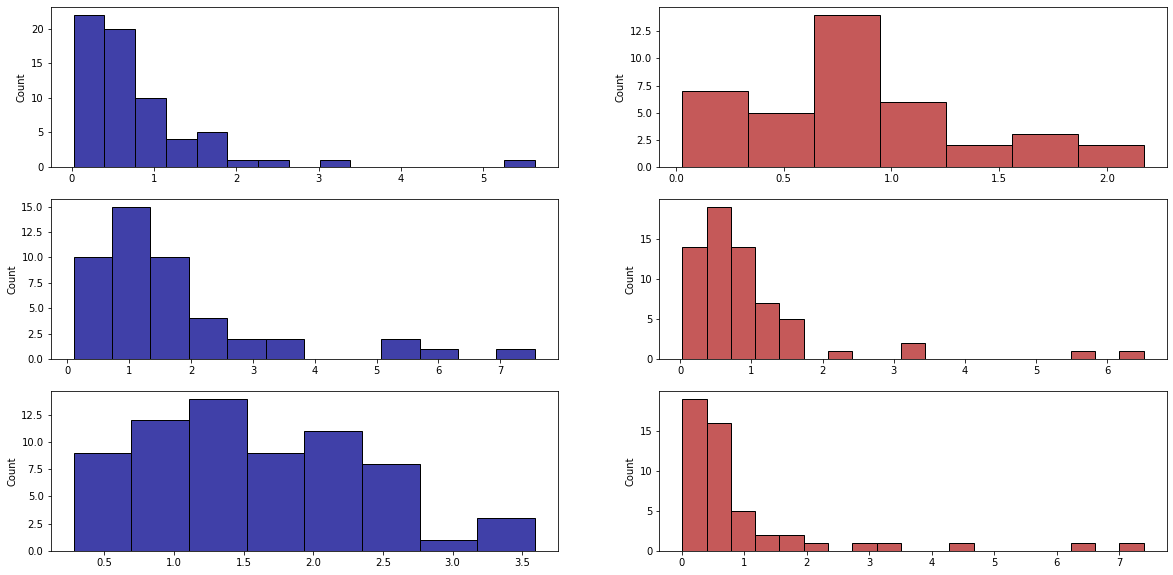

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20,10))
sns.histplot(data=max_responses[0][max_responses[0] > 0], ax=axs[0,0], color="darkblue")
sns.histplot(data=max_responses[1][max_responses[1] > 0], ax=axs[1,0], color="darkblue")
sns.histplot(data=max_responses[2][max_responses[2] > 0], ax=axs[2,0], color="darkblue")
sns.histplot(data=min_responses[0][min_responses[0] > 0], ax=axs[0,1], color="firebrick")
sns.histplot(data=min_responses[1][min_responses[1] > 0], ax=axs[1,1], color="firebrick")
sns.histplot(data=min_responses[2][min_responses[2] > 0], ax=axs[2,1], color="firebrick")

In [ ]:
transcript_featuers[transcript_featuers.PHQ8_Score == 0]["number_of_pauses"]

3    121
4    312
5     46
Name: number_of_pauses, dtype: int64

In [ ]:
transcript_featuers

,id,response_time,number_of_pauses,pause_times,PHQ8_Score
0,346,"[0.12, 0.35, 0.63, 1.13, 0.27, 0.57, 0.62, 1.1...",226,"[0.7, 0.75, 2.87, 0.53, 0.63, 0.37, 0.7, 0.54,...",23
1,308,"[1.26, 0.94, 1.06, 0.21, 6.3, 2.89, 2.28, -1.7...",104,"[1.11, 1.04, 1.39, 1.52, 5.83, 1.05, 2.78, 1.9...",22
2,311,"[0.52, 1.33, 2.65, 1.19, 1.61, 1.04, 0.62, 1.1...",61,"[0.61, 0.9, 0.94, 0.47, 0.88, 0.94, 0.84, 1.04...",21
3,363,"[0.15, 0.57, 0.81, 1.13, 0.7, 0.7, 0.03, 0.71,...",121,"[0.78, 0.51, 0.56, 0.46, 0.57, 0.67, 0.75, 0.6...",0
4,364,"[0.06, 0.45, 0.81, 0.7, 1.03, 0.31, 0.39, 0.1,...",312,"[0.49, 0.28, 0.59, 0.79, 0.21, 0.21, 0.57, 0.5...",0
5,303,"[0.28, 0.35, 0.13, 0.46, 0.63, 0.54, 0.25, 1.0...",46,"[1.72, 0.5, 0.49, 0.98, 1.18, 0.56, 0.53, 0.6,...",0


In [ ]:
all_test_labels =  pd.read_pickle("/content/drive/MyDrive/test_labels/y_test.pkl")
all_train_labels = pd.read_pickle("/content/drive/MyDrive/train_labels/y_train_dict.pkl")
all_valid_labels = pd.read_pickle("/content/drive/MyDrive/valid_labels/y_valid.pkl")
all_test_labels = list(all_test_labels.values())
all_train_labels = list(all_train_labels.values())
all_valid_labels = list(all_valid_labels.values())
all_test_labels = [item for sublist in all_test_labels for item in sublist]
all_train_labels = [item for sublist in all_train_labels for item in sublist]
all_valid_labels = [item for sublist in all_valid_labels for item in sublist]
all_labels = np.append(all_train_labels, all_test_labels, axis=0)
all_labels = np.append(all_labels, all_valid_labels, axis=0)
values, counts = np.unique(all_labels, return_counts=True)
print(all_labels.shape[0])
plt.figure(figsize=(8, 6))
_ = plt.bar(values, counts, width=.2)

In [ ]:
train_label_path = r'/content/drive/MyDrive/train_labels/depression'
valid_label_path = r'/content/drive/MyDrive/valid_labels/depression'
test_label_path = r'/content/drive/MyDrive/test_labels/depression/real'
predict_test_labels_path = r'/content/drive/MyDrive/test_labels/depression/predicted'

In [ ]:
train_labels = pd.read_csv("/content/drive/MyDrive/Depression/train_split_Depression_AVEC2017.csv").iloc[:, 0:4]
valid_labels = pd.read_csv("/content/drive/MyDrive/Depression/dev_split_Depression_AVEC2017.csv").iloc[:, 0:4]
test_labels = pd.read_csv("/content/drive/MyDrive/Depression/full_test_split.csv").iloc[:, 0:4]
test_labels.columns = ['Participant_ID',	'PHQ8_Binary',	'PHQ8_Score',	'Gender']

In [ ]:
scores_1 = train_labels.PHQ8_Score.to_numpy()
scores_2 = valid_labels.PHQ8_Score.to_numpy()
scores_3 = test_labels.PHQ8_Score.to_numpy()

In [ ]:
scores_1[scores_1 == 9]

array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [ ]:
scores_2.shape

(35,)

In [ ]:
scores_1 =np.append(scores_1, scores_2)

In [ ]:
scores_1 =np.append(scores_1, scores_3)

In [ ]:
scores_1[scores_1 == 10 ]

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

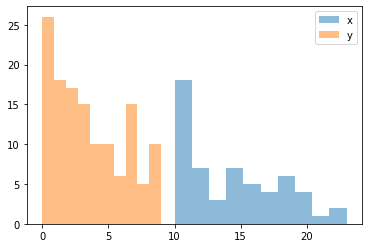

In [ ]:
import random
import numpy
from matplotlib import pyplot

# x = [random.gauss(3,1) for _ in range(400)]
# y = [random.gauss(4,2) for _ in range(400)]

x = scores_1[scores_1 >= 10 ]
y = scores_1[scores_1 < 10]
# bins = numpy.linspace(-10, 10, 100)

pyplot.hist(x, alpha=0.5, label='x')
pyplot.hist(y, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()

In [ ]:
non_depressd = scores_1[scores_1 not in depressd]

In [ ]:
scores_1[scores_1 < 10]

array([0, 6, 7, 4, 2, 7, 2, 6, 8, 3, 5, 5, 2, 4, 4, 5, 7, 1, 7, 9, 7, 7,
       4, 0, 0, 0, 7, 0, 0, 9, 2, 5, 2, 7, 8, 9, 1, 2, 5, 7, 9, 3, 3, 3,
       0, 6, 5, 0, 1, 3, 2, 0, 1, 7, 1, 0, 1, 2, 1, 1, 6, 3, 0, 0, 4, 0,
       0, 4, 6, 1, 7, 2, 4, 0, 0, 8, 4, 4, 8, 0, 9, 7, 0, 0, 2, 7, 3, 0,
       1, 4, 5, 3, 3, 2, 1, 9, 3, 2, 0, 2, 3, 0, 1, 1, 1, 5, 5, 0, 9, 1,
       2, 5, 7, 3, 0, 0, 3, 2, 1, 8, 2, 6, 9, 1, 9, 2, 9, 0, 3, 3, 1, 7])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


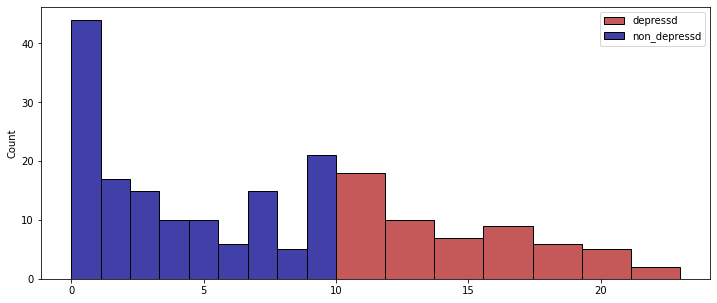

In [ ]:
import random
import numpy
from matplotlib import pyplot

depressd = scores_1[scores_1 >= 10 ]
non_depressd = scores_1[scores_1 not in depressd]


plt.figure(figsize=(12, 5))

_ =sns.histplot(scores_1[scores_1 > 9 ], label='depressd',color="firebrick")
_ = sns.histplot(scores_1[scores_1 <= 10], label='non_depressd',color="darkblue" )
_ = pyplot.legend(loc='upper right' )
_ = pyplot.show()

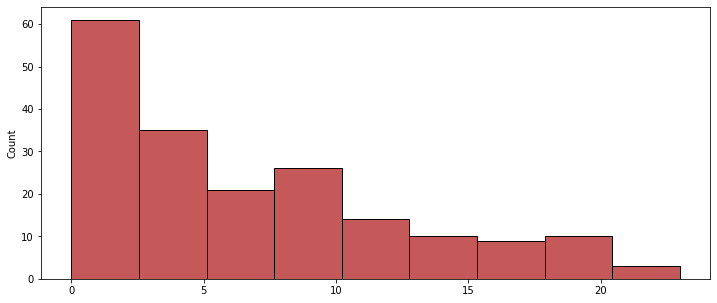

In [ ]:
plt.figure(figsize=(12, 5))
_ = sns.histplot(scores_1, color="firebrick")

In [ ]:
from scipy import stats


def findSilence(X, window_size=21, step=10):
    silences = []
    for i in range(0, len(X) - window_size, step):
        v = X[i:(i + window_size)]
        mode  = stats.mode(v)[0][0]
        silences.append(mode)
    return np.array(silences)



def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges



def lables_to_df(runs, df):
  df = pd.DataFrame(runs.items(), columns=["Participant_ID", "Number_of_silences"])
  df = df.sort_values("Participant_ID")
  df = df.reset_index(drop=True)
  return df




In [ ]:
def readlabels (path):
  all_silences = {}
  all_files = glob.glob(path + "/*")
  for filename in all_files:
      id = int(filename.split("/")[6].split(".")[0])
      labels = pd.read_pickle(filename)
      speak_silence = findSilence(labels).reshape(-1)
      silence_runs = zero_runs(speak_silence)
      silence_lens =silence_runs[:,1] - silence_runs[:,0]
      # silence_lens = silence_lens[silence_lens > 1]
      avg_length_of_silences = silence_lens.mean()
      avg_length_of_silences = float("{:.2f}".format(avg_length_of_silences))
      number_of_silences = np.unique(speak_silence, return_counts=1)[1][0]
      # avg_number_of_silences = number_of_silences / speak_silence.shape[0]
      all_silences[id] = [number_of_silences, silence_lens, avg_length_of_silences]
  return all_silences

In [ ]:
train_silences = readlabels(train_label_path)
valid_silences = readlabels(valid_label_path)
# test_silences = readlabels(test_label_path)

In [ ]:
train_silence, valid_silence, test_silence = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
train_silence = lables_to_df(train_silences, train_silence )
valid_silence = lables_to_df(valid_silences, valid_silence)
test_silence = lables_to_df(test_silences,  test_silence)
train_silence_labels =  pd.concat([train_labels, train_silence.iloc[:, 1:]], axis= 1)
valid_silence_labels =  pd.concat([valid_labels, valid_silence.iloc[:, 1:]], axis= 1)
test_silence_labels =  pd.concat([test_labels, test_silence.iloc[:, 1:]], axis= 1)

In [ ]:
lens, avg_len, nums = [], [], []
for id in train_silence_labels.Participant_ID : 
  avg_len.append(train_silence_labels[train_silence_labels.Participant_ID == id].Number_of_silences.iloc[0][2])
  lens.append(train_silence_labels[train_silence_labels.Participant_ID == id].Number_of_silences.iloc[0][1])
  nums.append(train_silence_labels[train_silence_labels.Participant_ID == id].Number_of_silences.iloc[0][0])

avg_len = np.array(avg_len)
lens = np.array(lens)
nums = np.array(nums)
train_silence_labels["Number_of_silences"] = nums
train_silence_labels["length_of_silences"] = lens
train_silence_labels["avg_length_of_silences"] = avg_len

In [ ]:
lens, avg_len, nums = [], [],[]
for id in test_silence_labels.Participant_ID : 
  avg_len.append(test_silence_labels[test_silence_labels.Participant_ID == id].Number_of_silences.iloc[0][2])
  lens.append(test_silence_labels[test_silence_labels.Participant_ID == id].Number_of_silences.iloc[0][1])
  nums.append(test_silence_labels[test_silence_labels.Participant_ID == id].Number_of_silences.iloc[0][0])

avg_len = np.array(avg_len)
lens = np.array(lens)
nums = np.array(nums)
test_silence_labels["Number_of_silences"] = nums
test_silence_labels["length_of_silences"] = lens
test_silence_labels["avg_length_of_silences"] = avg_len

In [ ]:
lens, avg_len, nums = [], [], []
for id in valid_silence_labels.Participant_ID : 
  avg_len.append(valid_silence_labels[valid_silence_labels.Participant_ID == id].Number_of_silences.iloc[0][2])
  lens.append(valid_silence_labels[valid_silence_labels.Participant_ID == id].Number_of_silences.iloc[0][1])
  nums.append(valid_silence_labels[valid_silence_labels.Participant_ID == id].Number_of_silences.iloc[0][0])

avg_len = np.array(avg_len)
lens = np.array(lens)
nums = np.array(nums)
valid_silence_labels["Number_of_silences"] = nums
valid_silence_labels["length_of_silences"] = lens
valid_silence_labels["avg_length_of_silences"] = avg_len

TrainSet

In [ ]:
train_silence_labels.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,Number_of_silences,length_of_silences,avg_length_of_silences
0,303,0,0,0,4699,"[15, 1, 6, 1, 1, 1, 6, 3, 2, 5, 4, 17, 1, 4, 4...",6.80
1,304,0,6,0,4680,"[3, 4, 2, 8, 6, 2, 2, 2, 1, 2, 8, 2, 8, 7, 2, ...",8.88
2,305,0,7,1,10501,"[8, 2, 15, 2, 5, 2, 10, 4, 6, 3, 1, 1, 6, 2, 3...",8.41
3,310,0,4,1,6670,"[35, 98, 3, 66, 47, 13, 23, 245, 12, 4, 14, 42...",16.89
4,312,0,2,1,5902,"[3, 12, 9, 1, 2, 8, 3, 4, 1, 6, 6, 2, 7, 5, 9,...",10.73


In [ ]:
res = stats.ttest_ind(train_silence_labels[train_silence_labels.PHQ8_Binary == 1].Number_of_silences,
                      train_silence_labels[train_silence_labels.PHQ8_Binary == 0].Number_of_silences, equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}') 

p-value for single sided test: 0.4673


In [ ]:
res = stats.ttest_ind(train_silence_labels[train_silence_labels.PHQ8_Binary == 1].avg_length_of_silences,
                      train_silence_labels[train_silence_labels.PHQ8_Binary == 0].avg_length_of_silences, equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}') 

p-value for single sided test: 0.2558


In [ ]:
g = sns.FacetGrid(train_silence_labels, col='PHQ8_Binary', height=5, aspect=1)
g.map(sns.histplot, "Number_of_silences")
plt.show()

In [ ]:
g = sns.FacetGrid(train_silence_labels, col='PHQ8_Binary', height=5, aspect=1)
g.map(sns.histplot, "avg_length_of_silences")
plt.show()

In [ ]:
plt.figure(figsize=(10, 30))
plt.subplot(2, 1, 1)
ax = sns.barplot(y="Participant_ID", x="Number_of_silences", data=train_silence_labels[train_silence_labels.PHQ8_Binary == 0], color="darkblue",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
plt.subplot(2, 1, 2)
ax = sns.barplot(y="Participant_ID", x="Number_of_silences" , data=train_silence_labels[train_silence_labels.PHQ8_Binary == 1], color="firebrick",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
# fig.savefig('test_runs.png', dpi=50)

In [ ]:
plt.figure(figsize=(10, 30))
plt.subplot(2, 1, 1)
ax = sns.barplot(y="Participant_ID", x="avg_length_of_silences", data=train_silence_labels[train_silence_labels.PHQ8_Binary == 0], color="darkblue",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
plt.subplot(2, 1, 2)
ax = sns.barplot(y="Participant_ID", x="avg_length_of_silences" , data=train_silence_labels[train_silence_labels.PHQ8_Binary == 1], color="firebrick",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
# fig.savefig('test_runs.png', dpi=50)

Validation Set


In [ ]:
valid_silence_labels.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,Number_of_silences,length_of_silences,avg_length_of_silences
0,302,0,4,1,5808,"[11, 13, 18, 2, 151, 75, 7, 2, 57, 3, 12, 12, ...",15.65
1,307,0,4,0,5285,"[3, 4, 2, 5, 2, 2, 5, 5, 1, 7, 2, 3, 2, 1, 47,...",6.76
2,331,0,8,1,5101,"[15, 79, 1, 25, 10, 7, 5, 4, 6, 1, 1, 7, 2, 1,...",9.27
3,335,1,12,0,4863,"[3, 58, 1, 4, 2, 4, 1, 1, 3, 5, 1, 1, 2, 2, 74...",7.52
4,346,1,23,0,7262,"[7, 10, 6, 3, 13, 63, 1, 3, 3, 1, 2, 2, 2, 2, ...",7.72


In [ ]:
res = stats.ttest_ind(valid_silence_labels[valid_silence_labels.PHQ8_Binary == 1].Number_of_silences,
                      valid_silence_labels[valid_silence_labels.PHQ8_Binary == 0].Number_of_silences, equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}') 

p-value for single sided test: 0.0018


In [ ]:
res = stats.ttest_ind(valid_silence_labels[valid_silence_labels.PHQ8_Binary == 1].avg_length_of_silences,
                      valid_silence_labels[valid_silence_labels.PHQ8_Binary == 0].avg_length_of_silences, equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}') 

p-value for single sided test: 0.2902


In [ ]:
g = sns.FacetGrid(valid_silence_labels, col='PHQ8_Binary', height=5, aspect=1)
g.map(sns.histplot, "Number_of_silences")
plt.show()

In [ ]:
g = sns.FacetGrid(valid_silence_labels, col='PHQ8_Binary', height=5, aspect=1)
g.map(sns.histplot, "avg_length_of_silences")
plt.show()

In [ ]:
plt.figure(figsize=(10, 30))
plt.subplot(2, 1, 1)
ax = sns.barplot(y="Participant_ID", x="Number_of_silences", data=valid_silence_labels[valid_silence_labels.PHQ8_Binary == 0], color="darkblue",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
plt.subplot(2, 1, 2)
ax = sns.barplot(y="Participant_ID", x="Number_of_silences" , data=valid_silence_labels[valid_silence_labels.PHQ8_Binary == 1], color="firebrick",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
# fig.savefig('test_runs.png', dpi=50)

In [ ]:
plt.figure(figsize=(10, 30))
plt.subplot(2, 1, 1)
ax = sns.barplot(y="Participant_ID", x="avg_length_of_silences", data=valid_silence_labels[valid_silence_labels.PHQ8_Binary == 0], color="darkblue",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
plt.subplot(2, 1, 2)
ax = sns.barplot(y="Participant_ID", x="avg_length_of_silences" , data=valid_silence_labels[valid_silence_labels.PHQ8_Binary == 1], color="firebrick",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
# fig.savefig('test_runs.png', dpi=50)

Test Set

In [ ]:
test_silence_labels.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,Number_of_silences,length_of_silences,avg_length_of_silences
0,300,0,2,1,3717,"[30, 1, 1, 5, 2, 7, 2, 1, 5, 21, 12, 10, 8, 2,...",10.44
1,301,0,3,1,4981,"[14, 7, 4, 2, 4, 6, 2, 2, 5, 2, 15, 3, 2, 3, 1...",7.55
2,306,0,0,0,4899,"[7, 2, 3, 6, 4, 22, 10, 2, 5, 1, 3, 2, 10, 58,...",6.37
3,308,1,22,0,6447,"[10, 9, 3, 1, 1, 9, 1, 30, 1, 48, 25, 41, 1, 2...",13.32
4,309,1,15,1,5324,"[7, 14, 27, 27, 4, 5, 19, 88, 1, 5, 86, 20, 4,...",16.85


In [ ]:
res = stats.ttest_ind(test_silence_labels[test_silence_labels.PHQ8_Binary == 1].Number_of_silences,
                      test_silence_labels[test_silence_labels.PHQ8_Binary == 0].Number_of_silences, equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}') 

p-value for single sided test: 0.0471


In [ ]:
res = stats.ttest_ind(test_silence_labels[test_silence_labels.PHQ8_Binary == 1].Number_of_silences,
                      test_silence_labels[test_silence_labels.PHQ8_Binary == 0].Number_of_silences, equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}') 

p-value for single sided test: 0.0471


In [ ]:
res = stats.ttest_ind(test_silence_labels[test_silence_labels.PHQ8_Binary == 1].avg_length_of_silences,
                      test_silence_labels[test_silence_labels.PHQ8_Binary == 0].avg_length_of_silences, equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}') 

p-value for single sided test: 0.0069


In [ ]:
g = sns.FacetGrid(test_silence_labels, col='PHQ8_Binary', size=5, aspect=1)
g.map(sns.histplot, "Number_of_silences")
plt.show()

In [ ]:
g = sns.FacetGrid(test_silence_labels, col='PHQ8_Binary', size=5, aspect=1)
g.map(sns.histplot, "avg_length_of_silences")
plt.show()

In [ ]:
plt.figure(figsize=(10, 30))
plt.subplot(2, 1, 1)
ax = sns.barplot(y="Participant_ID", x="Number_of_silences", data=test_silence_labels[test_silence_labels.PHQ8_Binary == 0], color="darkblue",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
plt.subplot(2, 1, 2)
ax = sns.barplot(y="Participant_ID", x="Number_of_silences" , data=test_silence_labels[test_silence_labels.PHQ8_Binary == 1], color="firebrick",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
# fig.savefig('test_runs.png', dpi=50)

In [ ]:
plt.figure(figsize=(10, 30))
plt.subplot(2, 1, 1)
ax = sns.barplot(y="Participant_ID", x="avg_length_of_silences", data=test_silence_labels[test_silence_labels.PHQ8_Binary == 0], color="darkblue",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
plt.subplot(2, 1, 2)
ax = sns.barplot(y="Participant_ID", x="avg_length_of_silences" , data=test_silence_labels[test_silence_labels.PHQ8_Binary == 1], color="firebrick",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
# fig.savefig('test_runs.png', dpi=50)

Predicted_set

In [ ]:
def readPredictedlabels (path):
  all_silences = {}
  all_files = glob.glob(path + "/*")
  for filename in all_files:
      id = int(filename.split("/")[7].split(".")[0])
      labels = pd.read_pickle(filename)
      for i in range(len(labels)):
        if labels[i] >= .5 :
          labels[i] = 1
        else :
          labels[i] = 0
      speak_silence = findSilence(labels).reshape(-1)
      silence_runs = zero_runs(speak_silence)
      silence_lens =silence_runs[:,1] - silence_runs[:,0]
      # silence_lens = silence_lens[silence_lens > 1]
      avg_length_of_silences = silence_lens.mean()
      avg_length_of_silences = float("{:.2f}".format(avg_length_of_silences))
      number_of_silences = np.unique(speak_silence, return_counts=1)[1][0]
      # avg_number_of_silences = number_of_silences / speak_silence.shape[0]
      all_silences[id] = [number_of_silences, silence_lens, avg_length_of_silences]
  return all_silences

In [ ]:
predicted_silences = readPredictedlabels(predict_test_labels_path)

In [ ]:
preditct_silence = pd.DataFrame()
preditct_silence = lables_to_df(predicted_silences,  preditct_silence)
preditct_silence_labels =  pd.concat([test_labels, preditct_silence.iloc[:, 1:]], axis= 1)

In [ ]:
lens, avg_len, nums = [], [], []
for id in preditct_silence_labels.Participant_ID : 
  avg_len.append(preditct_silence_labels[preditct_silence_labels.Participant_ID == id].Number_of_silences.iloc[0][2])
  lens.append(preditct_silence_labels[preditct_silence_labels.Participant_ID == id].Number_of_silences.iloc[0][1])
  nums.append(preditct_silence_labels[preditct_silence_labels.Participant_ID == id].Number_of_silences.iloc[0][0])

avg_len = np.array(avg_len)
lens = np.array(lens)
nums = np.array(nums)
preditct_silence_labels["Number_of_silences"] = nums
preditct_silence_labels["length_of_silences"] = lens
preditct_silence_labels["avg_length_of_silences"] = avg_len

In [ ]:
preditct_silence_labels.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,Number_of_silences,length_of_silences,avg_length_of_silences
0,300,0,2,1,5548,"[32, 2, 13, 19, 51, 9, 1, 10, 11, 2, 23, 2, 5,...",28.31
1,301,0,3,1,5607,"[11, 15, 14, 14, 11, 6, 31, 19, 286, 119, 35, ...",9.68
2,306,0,0,0,6490,"[11, 2, 1, 7, 2, 1, 3, 2, 6, 23, 8, 2, 3, 2, 6...",9.52
3,308,1,22,0,7257,"[10, 11, 2, 5, 2, 1, 2, 8, 5, 2, 24, 74, 1, 41...",16.57
4,309,1,15,1,5354,"[26, 4, 280, 4, 2, 24, 1, 20, 3, 5, 2, 1, 18, ...",24.90


In [ ]:
fig = plt.figure(figsize=(22,150))
for i in range(predicted_runs.shape[0]):
  values = predicted_runs.iloc[i].Runs_of_silences
  plt.subplot(27, 4, i+1)
  plt.title(predicted_runs.iloc[i].Participant_ID)
  plt.xlabel("succesive Silence")
  plt.ylabel("Counts")
  plt.hist(values)
fig.savefig('predicted_runs.png', dpi=100)

In [ ]:
res = stats.ttest_ind(preditct_silence_labels[preditct_silence_labels.PHQ8_Binary == 1].Number_of_silences,
                      preditct_silence_labels[preditct_silence_labels.PHQ8_Binary == 0].Number_of_silences, equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}') 

p-value for single sided test: 0.1356


In [ ]:
res = stats.ttest_ind(preditct_silence_labels[preditct_silence_labels.PHQ8_Binary == 1].avg_length_of_silences,
                      preditct_silence_labels[preditct_silence_labels.PHQ8_Binary == 0].avg_length_of_silences, equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}') 

p-value for single sided test: 0.0752


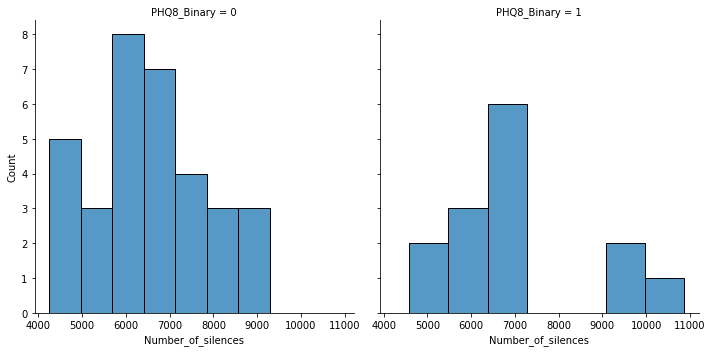

In [ ]:
g = sns.FacetGrid(preditct_silence_labels, col='PHQ8_Binary', height=5, aspect=1)
g.map(sns.histplot, "Number_of_silences")
plt.show()

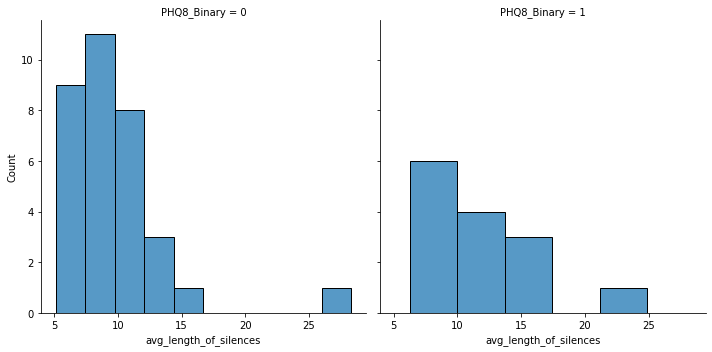

In [ ]:
g = sns.FacetGrid(preditct_silence_labels, col='PHQ8_Binary', height=5, aspect=1)
g.map(sns.histplot, "avg_length_of_silences")
plt.show()

In [ ]:
plt.figure(figsize=(10, 30))
plt.subplot(2, 1, 1)
ax = sns.barplot(y="Participant_ID", x="Number_of_silences", data=preditct_silence_labels[preditct_silence_labels.PHQ8_Binary == 0], color="darkblue",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
plt.subplot(2, 1, 2)
ax = sns.barplot(y="Participant_ID", x="Number_of_silences" , data=preditct_silence_labels[preditct_silence_labels.PHQ8_Binary == 1], color="firebrick",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
# fig.savefig('test_runs.png', dpi=50)

In [ ]:
plt.figure(figsize=(10, 30))
plt.subplot(2, 1, 1)
ax = sns.barplot(y="Participant_ID", x="avg_length_of_silences", data=preditct_silence_labels[preditct_silence_labels.PHQ8_Binary == 0], color="darkblue",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
plt.subplot(2, 1, 2)
ax = sns.barplot(y="Participant_ID", x="avg_length_of_silences" , data=preditct_silence_labels[preditct_silence_labels.PHQ8_Binary == 1], color="firebrick",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
# fig.savefig('test_runs.png', dpi=50)

In [ ]:
all_labels = pd.concat([train_labels, valid_labels])
all_labels = pd.concat([all_labels, test_labels])
all_labels = all_labels.reset_index()
all_labels = all_labels.iloc[:, 1:]

In [ ]:
all_labels.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender
0,303,0,0,0
1,304,0,6,0
2,305,0,7,1
3,310,0,4,1
4,312,0,2,1


In [ ]:
all_labels.iloc[147]

Participant_ID    311
PHQ8_Binary         1
PHQ8_Score         21
Gender              0
Name: 147, dtype: int64

In [ ]:
scores = all_labels.PHQ8_Score.to_numpy()

In [ ]:
np.where(scores == scores.min())

(array([  0,  41,  42,  43,  45,  46,  70,  74,  79,  84,  93,  94,  96,
         97, 104, 105, 115, 120, 121, 128, 141, 144, 157, 167, 169, 184]),)

In [ ]:
print("max : ")
for score in np.where(scores >= 20):
  print(scores[score], all_labels.iloc[score].Participant_ID)
print("min : ")
for score in np.where(scores == scores.min()):
  print(scores[score], all_labels.iloc[score].Participant_ID)

max : 
[20 20 20 20 23 22 21] 12     321
30     348
40     362
72     426
111    346
145    308
147    311
Name: Participant_ID, dtype: int64
min : 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 0      303
41     363
42     364
43     366
45     369
46     370
70     423
74     428
79     437
84     446
93     463
94     464
96     471
97     473
104    487
105    488
115    382
120    403
121    404
128    436
141    492
144    306
157    361
167    408
169    411
184    467
Name: Participant_ID, dtype: int64


In [ ]:
|

In [ ]:
all_ds = pd.concat([train_silence_labels, valid_silence_labels])
all_ds = pd.concat([all_ds, test_silence_labels])
all_ds = all_ds.reset_index()
all_ds = all_ds.iloc[:, 1:]

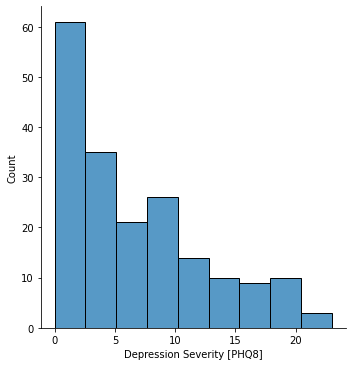

In [ ]:
ax = sns.displot(all_ds.PHQ8_Score.values)
ax.set(xlabel='Depression Severity [PHQ8]')

In [ ]:
all_ds.PHQ8_Binary.value_counts()

0    133
1     56
Name: PHQ8_Binary, dtype: int64

In [ ]:
all_ds.head()

,Participant_ID,PHQ8_Binary,PHQ8_Score,Gender,Number_of_silences,length_of_silences,avg_length_of_silences
0,303,0,0,0,4699,"[15, 1, 6, 1, 1, 1, 6, 3, 2, 5, 4, 17, 1, 4, 4...",6.80
1,304,0,6,0,4680,"[3, 4, 2, 8, 6, 2, 2, 2, 1, 2, 8, 2, 8, 7, 2, ...",8.88
2,305,0,7,1,10501,"[8, 2, 15, 2, 5, 2, 10, 4, 6, 3, 1, 1, 6, 2, 3...",8.41
3,310,0,4,1,6670,"[35, 98, 3, 66, 47, 13, 23, 245, 12, 4, 14, 42...",16.89
4,312,0,2,1,5902,"[3, 12, 9, 1, 2, 8, 3, 4, 1, 6, 6, 2, 7, 5, 9,...",10.73


In [ ]:
res = stats.ttest_ind(all_ds[all_ds.PHQ8_Binary == 1].Number_of_silences,
                      all_ds[all_ds.PHQ8_Binary == 0].Number_of_silences, equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}') 

p-value for single sided test: 0.0134


In [ ]:
res = stats.ttest_ind(all_ds[all_ds.PHQ8_Binary == 1].avg_length_of_silences,
                      all_ds[all_ds.PHQ8_Binary == 0].avg_length_of_silences, equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}') 

p-value for single sided test: 0.1097


In [ ]:
g = sns.FacetGrid(all_ds, col='PHQ8_Binary', height=5)
g.map(sns.histplot, "Number_of_silences")
plt.show()

In [ ]:
g = sns.FacetGrid(all_ds, col='PHQ8_Binary', height=5)
g.map(sns.histplot, "avg_length_of_silences")
plt.show()

In [ ]:
data=all_ds[all_ds.PHQ8_Binary == 0]
data.Number_of_silences.mean()

5702.1353383458645

In [ ]:
data=all_ds[all_ds.PHQ8_Binary == 1]
data.Number_of_silences.mean()

6316.928571428572

In [ ]:
data=all_ds[all_ds.PHQ8_Binary == 0]
data.avg_length_of_silences.mean()

9.090000000000002

In [ ]:
data=all_ds[all_ds.PHQ8_Binary == 1]
data.avg_length_of_silences.mean()

9.752857142857142

In [ ]:
plt.figure(figsize=(10, 50))
plt.subplot(2, 1, 1)
ax = sns.barplot(y="Participant_ID", x="avg_length_of_silences", data=all_ds[all_ds.PHQ8_Binary == 0], color="darkblue",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
plt.subplot(2, 1, 2)
ax = sns.barplot(y="Participant_ID", x="avg_length_of_silences" , data=all_ds[all_ds.PHQ8_Binary == 1], color="firebrick",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
# fig.savefig('test_runs.png', dpi=50)

In [ ]:
plt.figure(figsize=(10, 50))
plt.subplot(2, 1, 1)
ax = sns.barplot(y="Participant_ID", x="avg_length_of_silences", data=all_ds[all_ds.PHQ8_Binary == 0], color="darkblue",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
plt.subplot(2, 1, 2)
ax = sns.barplot(y="Participant_ID", x="avg_length_of_silences" , data=all_ds[all_ds.PHQ8_Binary == 1], color="firebrick",  orient = 'h')
ax.tick_params(axis='x', rotation=90)
# fig.savefig('test_runs.png', dpi=50)

In [ ]:
transcript_featuers

In [ ]:
transcript_featuers["response_mean"] = transcript_featuers.response_time.apply(lambda x: x.mean())

In [ ]:
transcript_featuers[transcript_featuers.PHQ8_bin == 1].response_mean.mean()

1.241130888775266

In [ ]:
mean_num_a = transcript_featuers[transcript_featuers.PHQ8_bin == 1].response_mean.mean()
mean_num_b = transcript_featuers[transcript_featuers.PHQ8_bin == 0].response_mean.mean()
print(mean_num_a - mean_num_b)

0.3524437601634498


In [ ]:
mean_avg_a = all_ds[all_ds.PHQ8_Binary == 1].avg_length_of_silences.mean()
mean_avg_b = all_ds[all_ds.PHQ8_Binary == 0].avg_length_of_silences.mean()
print(mean_avg_a - mean_avg_b)

0.6628571428571401


Text(0, 0.5, 'Frequency')

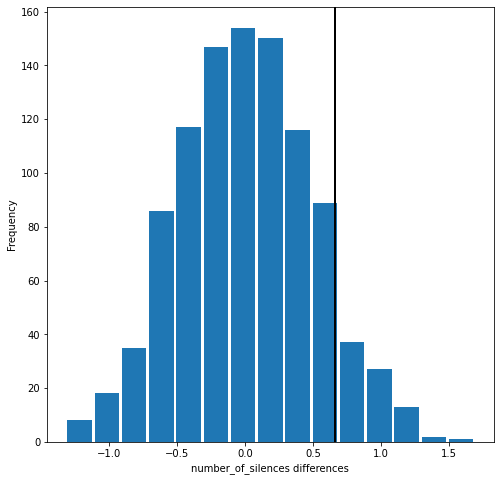

In [ ]:
perm_diffs = [perm(all_ds.avg_length_of_silences, 133, 56) for _ in range(1000)]
fig, ax = plt.subplots(figsize=(8, 8))
ax.hist(perm_diffs, bins=15, rwidth=0.9)
ax.axvline(x = mean_avg_a - mean_avg_b, color='black', lw=2)
# ax.text(-2, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('number_of_silences differences')
ax.set_ylabel('Frequency')

In [ ]:
import random
def perm(x, nA, nB):
  n = nA + nB
  idx_B = set(random.sample(range(n), nB))
  idx_A = set(range(n)) - idx_B
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()

Text(0, 0.5, 'Frequency')

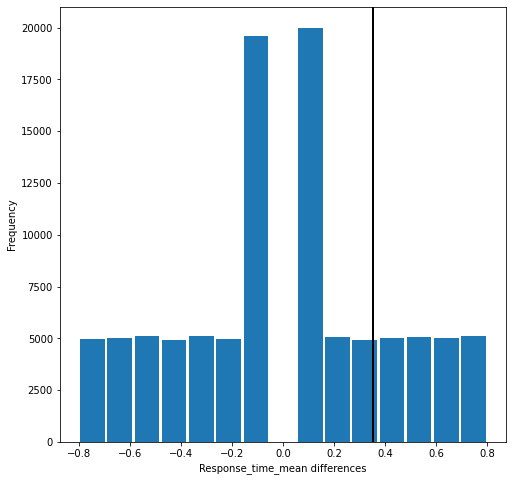

In [ ]:
perm_diffs = [perm(transcript_featuers.response_mean, 3, 3) for _ in range(100000)]
fig, ax = plt.subplots(figsize=(8, 8))
ax.hist(perm_diffs, bins=15, rwidth=0.9)
ax.axvline(x = mean_num_a - mean_num_b, color='black', lw=2)
# ax.text(-2, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Response_time_mean differences')
ax.set_ylabel('Frequency')

In [ ]:
train = pd.concat([train_silence_labels, valid_silence_labels])
X_train = train[["Number_of_silences", "avg_length_of_silences", "Gender"]].to_numpy()
y_train = train[["PHQ8_Binary"]].to_numpy()

In [ ]:
X_test= test_silence_labels[["Number_of_silences", "avg_length_of_silences", "Gender"]].to_numpy()
y_test = test_silence_labels[["PHQ8_Binary"]].to_numpy()

In [ ]:
y_test = y_test.reshape(-1,)
y_train = y_train.reshape(-1,)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf = make_pipeline(StandardScaler(), LogisticRegression())
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

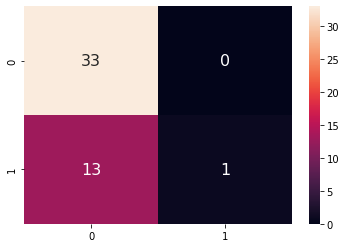

In [ ]:
predict = clf.predict(X_test)
from sklearn.metrics import confusion_matrix
a = confusion_matrix (y_test, predict)
import seaborn as sn
sn.heatmap(a, annot=True, annot_kws={"size": 16})

In [ ]:
def readlabels (path):
  all_runs = {}
  all_files = glob.glob(path + "/*")
  for filename in all_files:
      labels = pd.read_pickle(filename)
      labels = labels.reshape(labels.shape[0])
      for i in range(len(labels)):
        if labels[i] > .5 :
          labels[i] = 1
        else :
          labels[i] = 0
      runs = zero_runs(labels)
      runs_lenghts = runs[:,1] - runs[:,0]
      greater_than_50_runs = np.where(runs_lenghts >= 100)
      silence_time = runs_lenghts[greater_than_50_runs].sum()
      silence_avg = runs_lenghts[greater_than_50_runs].mean()
      all_runs[int(filename.split("/")[7].split(".")[0])] = [silence_time, np.array(greater_than_50_runs).shape[1], silence_avg]
  return all_runs

In [ ]:
predicted_test_zero_runs  = readlabels(predict_test_labels_path)

In [ ]:
def readlabels (path):
  all_runs = {}
  all_labels = {}
  all_files = glob.glob(path + "/*")
  for filename in all_files:
      labels = pd.read_pickle(filename)
      labels = labels.reshape(labels.shape[0])
      # all_labels[int(filename.split("/")[6].split(".")[0])] = labels
      runs = zero_runs(labels)
      runs_lenghts = runs[:,1] - runs[:,0]
      greater_than_50_runs = np.where(runs_lenghts >= 100)
      silence_time = runs_lenghts[greater_than_50_runs].sum() 
      silence_avg = runs_lenghts[greater_than_50_runs].mean()
      all_runs[int(filename.split("/")[6].split(".")[0])] = [silence_time, np.array(greater_than_50_runs).shape[1], silence_avg]
  return all_runs

In [ ]:
train_zero_runs = readlabels(train_label_path)
valid_zero_runs = readlabels(valid_label_path)
# real_test_zero_runs  = readlabels(test_label_path)

In [ ]:
def zero_runs(a):
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(a, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

In [ ]:
test_labels

In [ ]:
ids = np.array(list(train_zero_runs.keys()))
ids = ids.reshape(ids.shape[0], 1)
runs = np.array(list(train_zero_runs.values()))[:, 1]
runs = runs.reshape(runs.shape[0], 1)
times = np.array(list(train_zero_runs.values()))[:, 0]
times = times.reshape(runs.shape[0], 1)
avg = np.array(list(train_zero_runs.values()))[:, 2]
avg = avg.reshape(runs.shape[0], 1)
times = np.append(times, avg, axis=1)
runs = np.append(runs, times, axis=1)
index_runs = np.append(ids, runs, axis=1)
index_runs = index_runs[index_runs[:, 0].argsort()]
train_labels["number_of_silences"] = index_runs[:, 1]
train_labels["time_of_silences"] = index_runs[:, 2]
train_labels["mean_of_silences"] = index_runs[:, 3]

In [ ]:
ids = np.array(list(valid_zero_runs.keys()))
ids = ids.reshape(ids.shape[0], 1)
runs = np.array(list(valid_zero_runs.values()))[:, 1]
runs = runs.reshape(runs.shape[0], 1)
times = np.array(list(valid_zero_runs.values()))[:, 0]
times = times.reshape(runs.shape[0], 1)
avg = np.array(list(valid_zero_runs.values()))[:, 2]
avg = avg.reshape(runs.shape[0], 1)
times = np.append(times, avg, axis=1)
runs = np.append(runs, times, axis=1)
index_runs = np.append(ids, runs, axis=1)
index_runs = index_runs[index_runs[:, 0].argsort()]
valid_labels["number_of_silences"] = index_runs[:, 1]
valid_labels["time_of_silences"] = index_runs[:, 2]
valid_labels["mean_of_silences"] = index_runs[:, 3]

In [ ]:
ids = np.array(list(real_test_zero_runs.keys()))
ids = ids.reshape(ids.shape[0], 1)
runs = np.array(list(real_test_zero_runs.values()))[:, 1]
runs = runs.reshape(runs.shape[0], 1)
times = np.array(list(real_test_zero_runs.values()))[:, 0]
times = times.reshape(runs.shape[0], 1)
avg = np.array(list(real_test_zero_runs.values()))[:, 2]
avg = avg.reshape(runs.shape[0], 1)
times = np.append(times, avg, axis=1)
runs = np.append(runs, times, axis=1)
index_runs = np.append(ids, runs, axis=1)
index_runs = index_runs[index_runs[:, 0].argsort()]
test_labels["number_of_silences"] = index_runs[:, 1]
test_labels["time_of_silences"] = index_runs[:, 2]
test_labels["mean_of_silences"] = index_runs[:, 3]

In [ ]:
plt.figure(figsize=(20, 5))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
all_ds.query('PHQ8_Binary == 0').number_of_silences.plot(kind='bar')

In [ ]:
plt.figure(figsize=(20, 5))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
all_ds.query('PHQ8_Binary == 1').number_of_silences.plot(kind='bar')

In [ ]:
import matplotlib
x = all_ds.Participant_ID.to_numpy()
y = all_ds.number_of_silences.to_numpy()
label = all_ds.PHQ8_Binary.to_numpy()
colors = ['blue','red']

fig = plt.figure(figsize=(16,8))
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))

In [ ]:
import matplotlib
x = all_ds.Participant_ID.to_numpy()
y = all_ds.time_of_silences.to_numpy()
label = all_ds.PHQ8_Binary.to_numpy()
colors = ['blue','red']

fig = plt.figure(figsize=(16,8))
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))

In [ ]:
ids = np.array(list(predicted_test_zero_runs.keys()))
ids = ids.reshape(ids.shape[0], 1)
runs = np.array(list(predicted_test_zero_runs.values()))[:, 1]
runs = runs.reshape(runs.shape[0], 1)
times = np.array(list(predicted_test_zero_runs.values()))[:, 0]
times = times.reshape(runs.shape[0], 1)
avg = np.array(list(predicted_test_zero_runs.values()))[:, 2]
avg = avg.reshape(runs.shape[0], 1)
times = np.append(times, avg, axis=1)
runs = np.append(runs, times, axis=1)
index_runs = np.append(ids, runs, axis=1)
index_runs = index_runs[index_runs[:, 0].argsort()]
test_labels["number_of_silences"] = index_runs[:, 1]
test_labels["time_of_silences"] = index_runs[:, 2]
test_labels["mean_of_silences"] = index_runs[:, 3]

In [ ]:
test_labels.columns = ["Participant_ID", 'PHQ8_Binary',	"PHQ8_Score", "Gender",	"number_of_silences",	"time_of_silences",	"mean_of_silences"]

In [ ]:
a = pd.concat([train_labels, test_labels], axis=0)

In [ ]:
all_ds = pd.concat([a, valid_labels], ignore_index=True)

In [ ]:
all_ds.PHQ8_Binary.value_counts()

0    133
1     56
Name: PHQ8_Binary, dtype: int64

In [ ]:
mean_num_a = all_ds[all_ds.PHQ8_Binary == 1].number_of_silences.mean()
mean_time_a = all_ds[all_ds.PHQ8_Binary == 1].time_of_silences.mean()
mean_num_b = all_ds[all_ds.PHQ8_Binary == 0].number_of_silences.mean()
mean_time_b = all_ds[all_ds.PHQ8_Binary == 0].time_of_silences.mean()

In [ ]:
mean_num_a - mean_num_b

24.992481203007515

In [ ]:
mean_time_a - mean_time_b

4721.079887218042

In [ ]:
mean_num_a = all_ds[all_ds.PHQ8_Binary == 1].number_of_silences.mean()
mean_time_a = all_ds[all_ds.PHQ8_Binary == 1].time_of_silences.mean()
mean_num_b = all_ds[all_ds.PHQ8_Binary == 0].number_of_silences.mean()
mean_time_b = all_ds[all_ds.PHQ8_Binary == 0].time_of_silences.mean()

In [ ]:
mean_num_a - mean_num_b

21.476503759398497

In [ ]:
mean_time_a - mean_time_b

3570.54605263158

In [ ]:
res = stats.ttest_ind(all_ds[all_ds.PHQ8_Binary == 1].number_of_silences,
                      all_ds[all_ds.PHQ8_Binary == 0].number_of_silences, equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}') 
res = stats.ttest_ind(all_ds[all_ds.PHQ8_Binary == 1].time_of_silences,
                      all_ds[all_ds.PHQ8_Binary == 0].time_of_silences, equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.0017
p-value for single sided test: 0.0074


In [ ]:
res = stats.ttest_ind(all_ds[all_ds.PHQ8_Binary == 1].number_of_silences,
                      all_ds[all_ds.PHQ8_Binary == 0].number_of_silences, equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}') 
res = stats.ttest_ind(all_ds[all_ds.PHQ8_Binary == 1].time_of_silences,
                      all_ds[all_ds.PHQ8_Binary == 0].time_of_silences, equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.0053
p-value for single sided test: 0.0276


In [ ]:
import random
def perm(x, nA, nB):
  n = nA + nB
  idx_B = set(random.sample(range(n), nB))
  idx_A = set(range(n)) - idx_B
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()

Text(0, 0.5, 'Frequency')

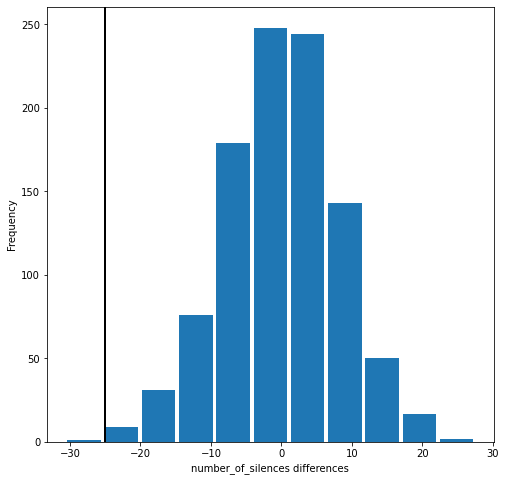

In [ ]:
perm_diffs = [perm(all_ds.number_of_silences, 133, 56) for _ in range(1000)]
fig, ax = plt.subplots(figsize=(8, 8))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_num_b - mean_num_a, color='black', lw=2)
# ax.text(-2, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('number_of_silences differences')
ax.set_ylabel('Frequency')

Text(0, 0.5, 'Frequency')

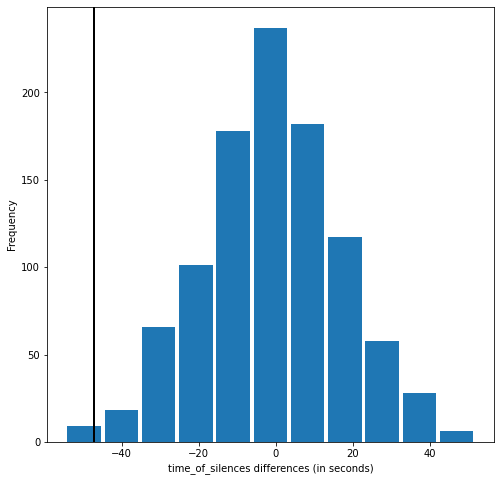

In [ ]:
perm_diffs = [perm(all_ds.time_of_silences, 133, 56) for _ in range(1000)]
fig, ax = plt.subplots(figsize=(8, 8))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_time_b - mean_time_a, color='black', lw=2)
# ax.text(-2, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('time_of_silences differences (in seconds)')
ax.set_ylabel('Frequency')

In [ ]:
train.drop(["PHQ8_Binary", "PHQ8_Score"], axis=1)

,Participant_ID,Gender,number_of_silences,time_of_silences,mean_of_silences
0,303,0,57.0,7307.0,128.192982
1,304,0,84.0,11467.0,136.511905
2,305,1,246.0,37926.0,154.170732
3,310,1,189.0,46674.0,246.952381
4,312,1,150.0,34378.0,229.186667
...,...,...,...,...,...
30,483,1,312.0,50736.0,162.615385
31,484,0,149.0,26609.0,178.583893
32,489,1,176.0,40133.0,228.028409
33,490,1,157.0,37352.0,237.910828


In [ ]:
train = pd.concat([train_labels, valid_labels], axis=0)
X_train = train.drop(["PHQ8_Binary", "PHQ8_Score"], axis=1).to_numpy()
y_train = train[["PHQ8_Binary"]].to_numpy()

In [ ]:
X_test= test_labels.drop(["PHQ8_Binary", "PHQ8_Score"], axis=1).to_numpy()
y_test = test_labels[["PHQ8_Binary"]].to_numpy()

In [ ]:
y_test = y_test.reshape(-1,)
y_train = y_train.reshape(-1,)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf = make_pipeline(StandardScaler(), LogisticRegression())
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

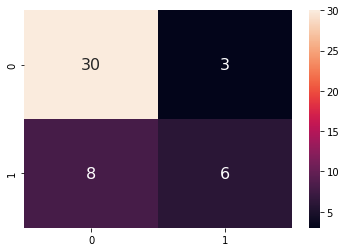

In [ ]:
predict = clf.predict(X_test)
from sklearn.metrics import confusion_matrix
a = confusion_matrix (y_test, predict)
import seaborn as sn
sn.heatmap(a, annot=True, annot_kws={"size": 16})

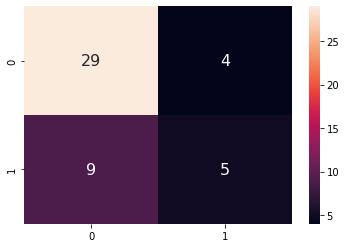

In [ ]:
predict = clf.predict(X_test)
from sklearn.metrics import confusion_matrix
a = confusion_matrix (y_test, predict)
import seaborn as sn
sn.heatmap(a, annot=True, annot_kws={"size": 16})